### Noise

In [1]:
import torch
import numpy as np
from tqdm import tqdm


from cellot.train.utils import get_free_gpu
replica_id = int(get_free_gpu())
device = torch.device(f'cuda:{replica_id}')
from cellot.models.cond_score_module import Pred_X_0_Parameterization
from cellot.data.utils import *

/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Using GPUs: 3


In [2]:
import hydra
with hydra.initialize('../configs/diff/'):
    config = hydra.compose(config_name='pred_x_0.yaml')

/tmp/ipykernel_2362143/1750149385.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize('../configs/diff/'):
/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'pred_x_0.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
# %%
import cellot.models
from cellot.data.cell import load_cell_data
import torch
from cellot.models.ae import AutoEncoder
from pathlib import Path

def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("ae", {})))
        name = kwargs.pop("name")

        # if name == "scgen":
        model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        # else:
        #     raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        # if config.model.name == "scgen" and "code_means" in ckpt:
        #     model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    return model, opt, loader
# %% [markdown]
# ### Training

# %%
# restore_path = '/Mounts/rbg-storage1/users/johnyang/cellot/saved_weights/ae/ae.pt'
# ae, _ = load_model(config, 'cuda', restore=restore_path, input_dim=1000)
# autoencoder = ae.to(device)

In [14]:
adata = read_single_anndata(config)
adata

AnnData object with n_obs × n_vars = 762039 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'

In [15]:
adata.obs['cell_type']

A01_E09_RT_BC_100_Lig_BC_147    MCF7
A01_E09_RT_BC_100_Lig_BC_186    MCF7
A01_E09_RT_BC_100_Lig_BC_196    MCF7
A01_E09_RT_BC_100_Lig_BC_213    A549
A01_E09_RT_BC_100_Lig_BC_220    K562
                                ... 
H12_F10_RT_BC_9_Lig_BC_23       MCF7
H12_F10_RT_BC_9_Lig_BC_237      MCF7
H12_F10_RT_BC_9_Lig_BC_274      K562
H12_F10_RT_BC_9_Lig_BC_291      MCF7
H12_F10_RT_BC_9_Lig_BC_298      MCF7
Name: cell_type, Length: 762039, dtype: category
Categories (3, object): ['A549', 'K562', 'MCF7']

In [17]:
adata.uns['pca']

{'params': {'use_highly_variable': True, 'zero_center': True},
 'variance': array([58.35394035, 45.93642312, 10.38586855,  5.37223373,  3.61717592,
         3.14349514,  2.71372327,  2.44640589,  2.23637256,  2.00485655,
         1.88397741,  1.7852676 ,  1.69826406,  1.60682456,  1.53883304,
         1.44881456,  1.37832103,  1.36027386,  1.33628474,  1.31604444,
         1.25979397,  1.23000953,  1.20062812,  1.16600115,  1.14155601,
         1.11677403,  1.08564164,  1.06819689,  1.06277935,  1.04460153,
         1.03426051,  1.02655289,  1.01918334,  1.01718771,  0.99750111,
         0.98974715,  0.98339256,  0.9766009 ,  0.9689849 ,  0.95739738,
         0.94748621,  0.9408946 ,  0.93802056,  0.93362167,  0.92261008,
         0.91952132,  0.91654091,  0.90574953,  0.90205172,  0.89926241]),
 'variance_ratio': array([0.07735005, 0.06089023, 0.01376681, 0.00712107, 0.00479468,
        0.00416681, 0.00359713, 0.00324279, 0.00296438, 0.0026575 ,
        0.00249727, 0.00236643, 0.00225

In [18]:
import matplotlib.pyplot as plt

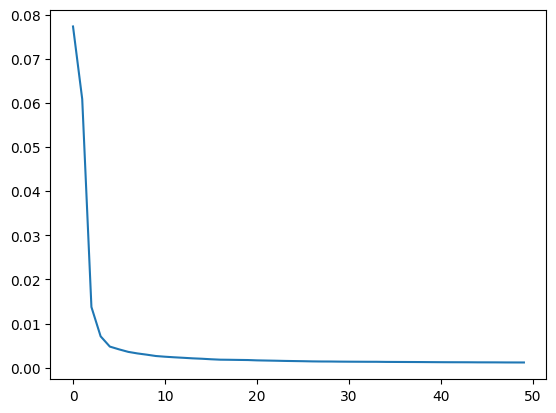

In [19]:
plt.plot(adata.uns['pca']['variance_ratio'])

In [20]:
# assuming your anndata object is named 'adata'
cell_types = adata.obs['cell_type'].unique() # get unique cell types
cell_type_data = {} # dictionary to store data for each cell type
for ct in cell_types:
    cell_type_data[ct] = adata[adata.obs['cell_type'] == ct]

In [21]:
cell_type_data

{'MCF7': View of AnnData object with n_obs × n_vars = 344764 × 1000
     obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
     var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'pca', 'rank_genes_groups'
     obsm: 'X_pca'
     varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score',
 'A549': View of AnnData object with n_obs × n_vars = 244126 × 1000
     obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
     var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'pca', 'rank_genes_groups'
     obsm: 'X_pca'
     varm: 'PCs', 'marker_g

In [92]:
mcf7 = cell_type_data['MCF7']
a549 = cell_type_data['A549']
k562 = cell_type_data['K562']

In [32]:
import umap

In [93]:
# Convert d_codes list into a numpy array
# d_codes_arr = np.concatenate(mcf7, axis=0)

# Extract labels from gts
# labels = torch.cat([item[1] for item in gts], dim=0).cpu().numpy()

# UMAP transformation
reducer = umap.UMAP()
mcf7_embedding = reducer.fit_transform(mcf7)

KeyboardInterrupt: 

In [94]:
drugs = ['control', 'abexinostat', 'trametinib']

In [95]:
drugs_only_mcf7 = cell_type_data['MCF7'][cell_type_data['MCF7'].obs['drug'].isin(drugs)]

In [96]:
drugs_only_mcf7.X.toarray().shape

(11535, 1000)

In [97]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(drugs_only_mcf7.X.toarray())

In [98]:
labels = drugs_only_mcf7.obs['drug'].values
labels

['abexinostat', 'trametinib', 'control', 'trametinib', 'control', ..., 'control', 'control', 'control', 'control', 'control']
Length: 11535
Categories (3, object): ['abexinostat', 'trametinib', 'control']

In [99]:
def color_labels(labels):
    # create a color map for each cell type
    colors = plt.cm.Spectral(np.linspace(0, 1, len(labels.unique())))

    # create a dictionary to map cell types to colors
    color_dict = dict(zip(labels.unique(), colors))

    # create a list of colors for each cell
    cell_colors = [color_dict[ct] for ct in labels]
    
    # create a legend with color patches for each cell type
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=ct, markerfacecolor=color_dict[ct], markersize=10) for ct in labels.unique()]
    return cell_colors, legend_elements

In [100]:
def plot_umap_embedding(embedding, cell_colors, name, legend_elements):
    
    # Create a scatter plot with labels
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cell_colors, cmap='Spectral')

    # Create a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Labels')

    plt.legend(handles=legend_elements, loc='best')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP of Cell Type {name} SC Data', fontsize=24)
    plt.show()

In [101]:
mcf7_cell_colors, mcf7_le = color_labels(drugs_only_mcf7.obs['drug'])

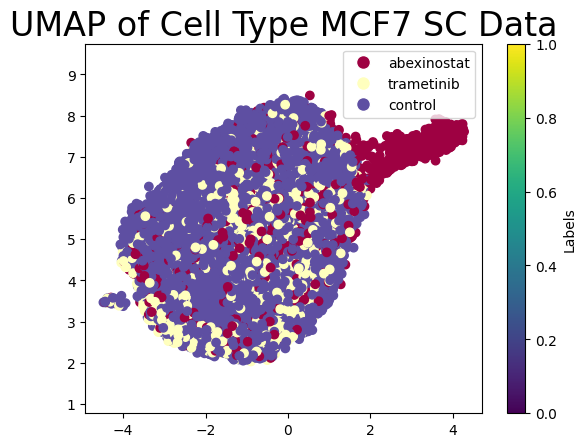

In [103]:
mcf7_embedding = embedding
plot_umap_embedding(mcf7_embedding, mcf7_cell_colors, 'MCF7', mcf7_le)

In [86]:
drugs_only_a549 = a549[a549.obs['drug'].isin(drugs)]
drugs_only_a549

View of AnnData object with n_obs × n_vars = 8512 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'

In [87]:
a549_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation')
a549_embedding = a549_umap.fit_transform(drugs_only_a549.X.toarray())

In [88]:
a549_cell_colors, a549_le = color_labels(drugs_only_a549.obs['drug'])

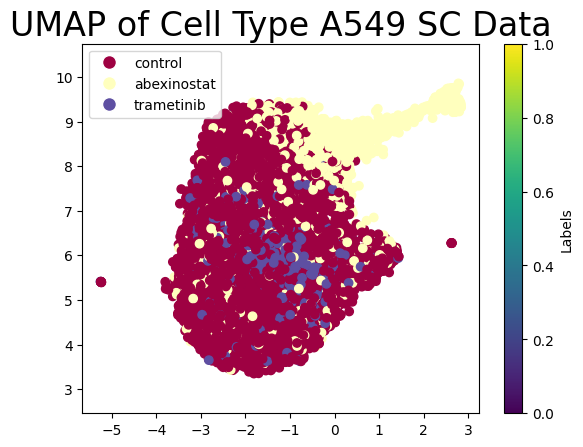

In [89]:
plot_umap_embedding(a549_embedding, a549_cell_colors, 'A549', a549_le)

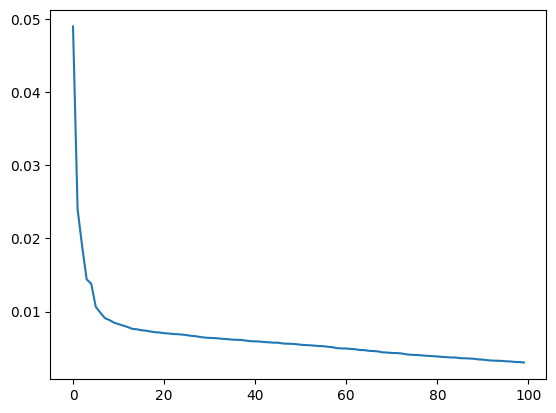

In [91]:
'''PCA'''
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit_transform(drugs_only_a549.X.toarray())
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

In [104]:
drugs_only_k562 = k562[k562.obs['drug'].isin(drugs)]
drugs_only_k562

View of AnnData object with n_obs × n_vars = 5300 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes', 'transport', 'split'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'

In [108]:
def sweep_umap(data):
    embeddings = []
    for nn in [3, 5, 10, 15, 30]:
        umap_ = umap.UMAP(n_neighbors=nn)
        embeddings.append(umap_.fit_transform(data))
    return embeddings

In [109]:
k562_umaps = sweep_umap(drugs_only_k562.X.toarray())

In [110]:
def plot_from_umap(umap_, adata, name):
    cc, le = color_labels(adata.obs['drug'])
    plot_umap_embedding(umap_, cc, name, le)

In [ ]:
plot_from_umap(umap, cell_type, "UMAP by cell type", "umap_by_cell_type")

In [105]:
k562_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation')
k562_embedding = k562_umap.fit_transform(drugs_only_k562.X.toarray())

In [106]:
k562_cell_colors, k562_le = color_labels(drugs_only_k562.obs['drug'])

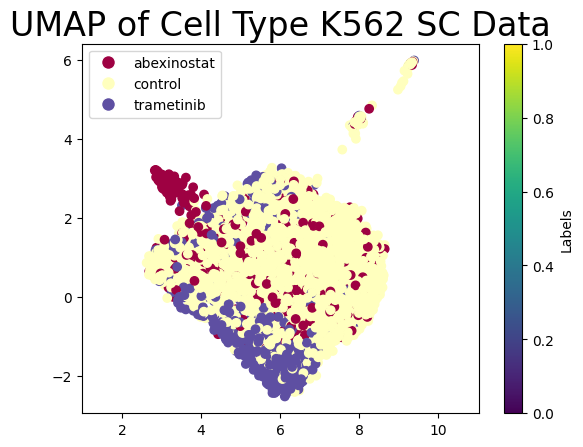

In [107]:
plot_umap_embedding(k562_embedding, k562_cell_colors, 'K562', k562_le)

In [89]:
all_recons = np.concatenate(recons, axis=0)

In [90]:
all_recons.shape

(3513, 1000)

In [91]:
target = datasets.test.target.adata.X
target.shape

(656, 1000)

In [94]:
def compute_mmd_on_selected_genes(recon, target, selected_genes, gammas):
    return compute_mmd_loss(recon[:, selected_genes], target[:, selected_genes], gammas)

In [95]:
gt_xs = torch.cat([x[0] for x in gts], axis=0).cpu().numpy()

In [96]:
np.mean((all_recons - gt_xs)**2)

4.5430857e-05

In [60]:
mmd_loss = compute_mmd_on_selected_genes(all_recons, target, gene_idxs, gammas)

In [97]:
all_recons

array([[ 2.94159818e+00, -1.23974867e-04,  5.87972638e-04, ...,
        -1.27846288e-04,  2.67872028e-03,  1.32063346e-03],
       [ 3.06497957e-03, -2.51156918e-04, -6.46121043e-05, ...,
         4.19995573e-04,  1.32817819e-04,  1.36199465e-04],
       [-1.94318680e-04, -4.45412297e-05,  5.95314026e-01, ...,
         4.21398378e-04, -4.59749252e-04,  1.12413545e-04],
       ...,
       [ 8.65801703e-04, -1.47733517e-05, -6.00854517e-04, ...,
         1.76629837e-04,  4.05028084e-04,  3.92630725e-04],
       [-3.73917399e-03,  7.04736565e-04, -9.16804827e-04, ...,
        -6.21540821e-04,  2.58531159e-04, -6.40580081e-04],
       [ 2.57340004e-03, -1.89418774e-04,  9.44990432e-04, ...,
         4.51400789e-04,  1.48261432e-03,  3.63497238e-04]], dtype=float32)

In [98]:
mmd_loss

0.01700967229437083

In [30]:
tgts = []
for batch in loader.train.target:
    tgts.append(batch[0])

In [99]:
import matplotlib.pyplot as plt
import numpy as np

def plot_marker_gene_expression(all_gts, target, all_recon, all_uncond_recons, gene_idxs, gene_names, cutoff=0.1, font_size=32, fig_title='Top 5 Marker Gene Expression Histograms for Trametinib Perturbation'):
    # Prepare figure and axes
    fig, axs = plt.subplots(len(gene_idxs), 4, figsize=(50, 40))
    plt.rcParams.update({'font.size': font_size})  # Update font size

    for i in range(len(gene_idxs)):
        # Extract values
        source_values = all_gts[:, gene_idxs[i]]
        target_values = target[:, gene_idxs[i]]
        recon_values = all_recon[:, gene_idxs[i]]
        uncond_recon_values = all_uncond_recons[:, gene_idxs[i]]
        # latent_iden_recon_values = all_latent_identities[:, gene_idxs[i]]

        # Create subplots
        axs[i][0].hist(source_values[source_values > cutoff])
        axs[i][0].set_title('Source')
        axs[i][1].hist(target_values[target_values > cutoff])
        axs[i][1].set_title('Target')
        axs[i][2].hist(recon_values[recon_values > cutoff])
        axs[i][2].set_title('Cond Recon')
        axs[i][3].hist(uncond_recon_values[uncond_recon_values > cutoff])
        axs[i][3].set_title('Uncond Recon')
        # axs[i][4].hist(latent_iden_recon_values[latent_iden_recon_values > cutoff])
        # axs[i][4].set_title('Latent Iden Recon')

        axs[i][0].set_ylabel(gene_names[i])

    # Adjust figure and show
    fig.subplots_adjust(top=0.95)  # Adjust as needed
    fig.suptitle(fig_title)
    plt.show()


In [100]:
all_uncond_recons = np.concatenate(uncond_recons, axis=0)

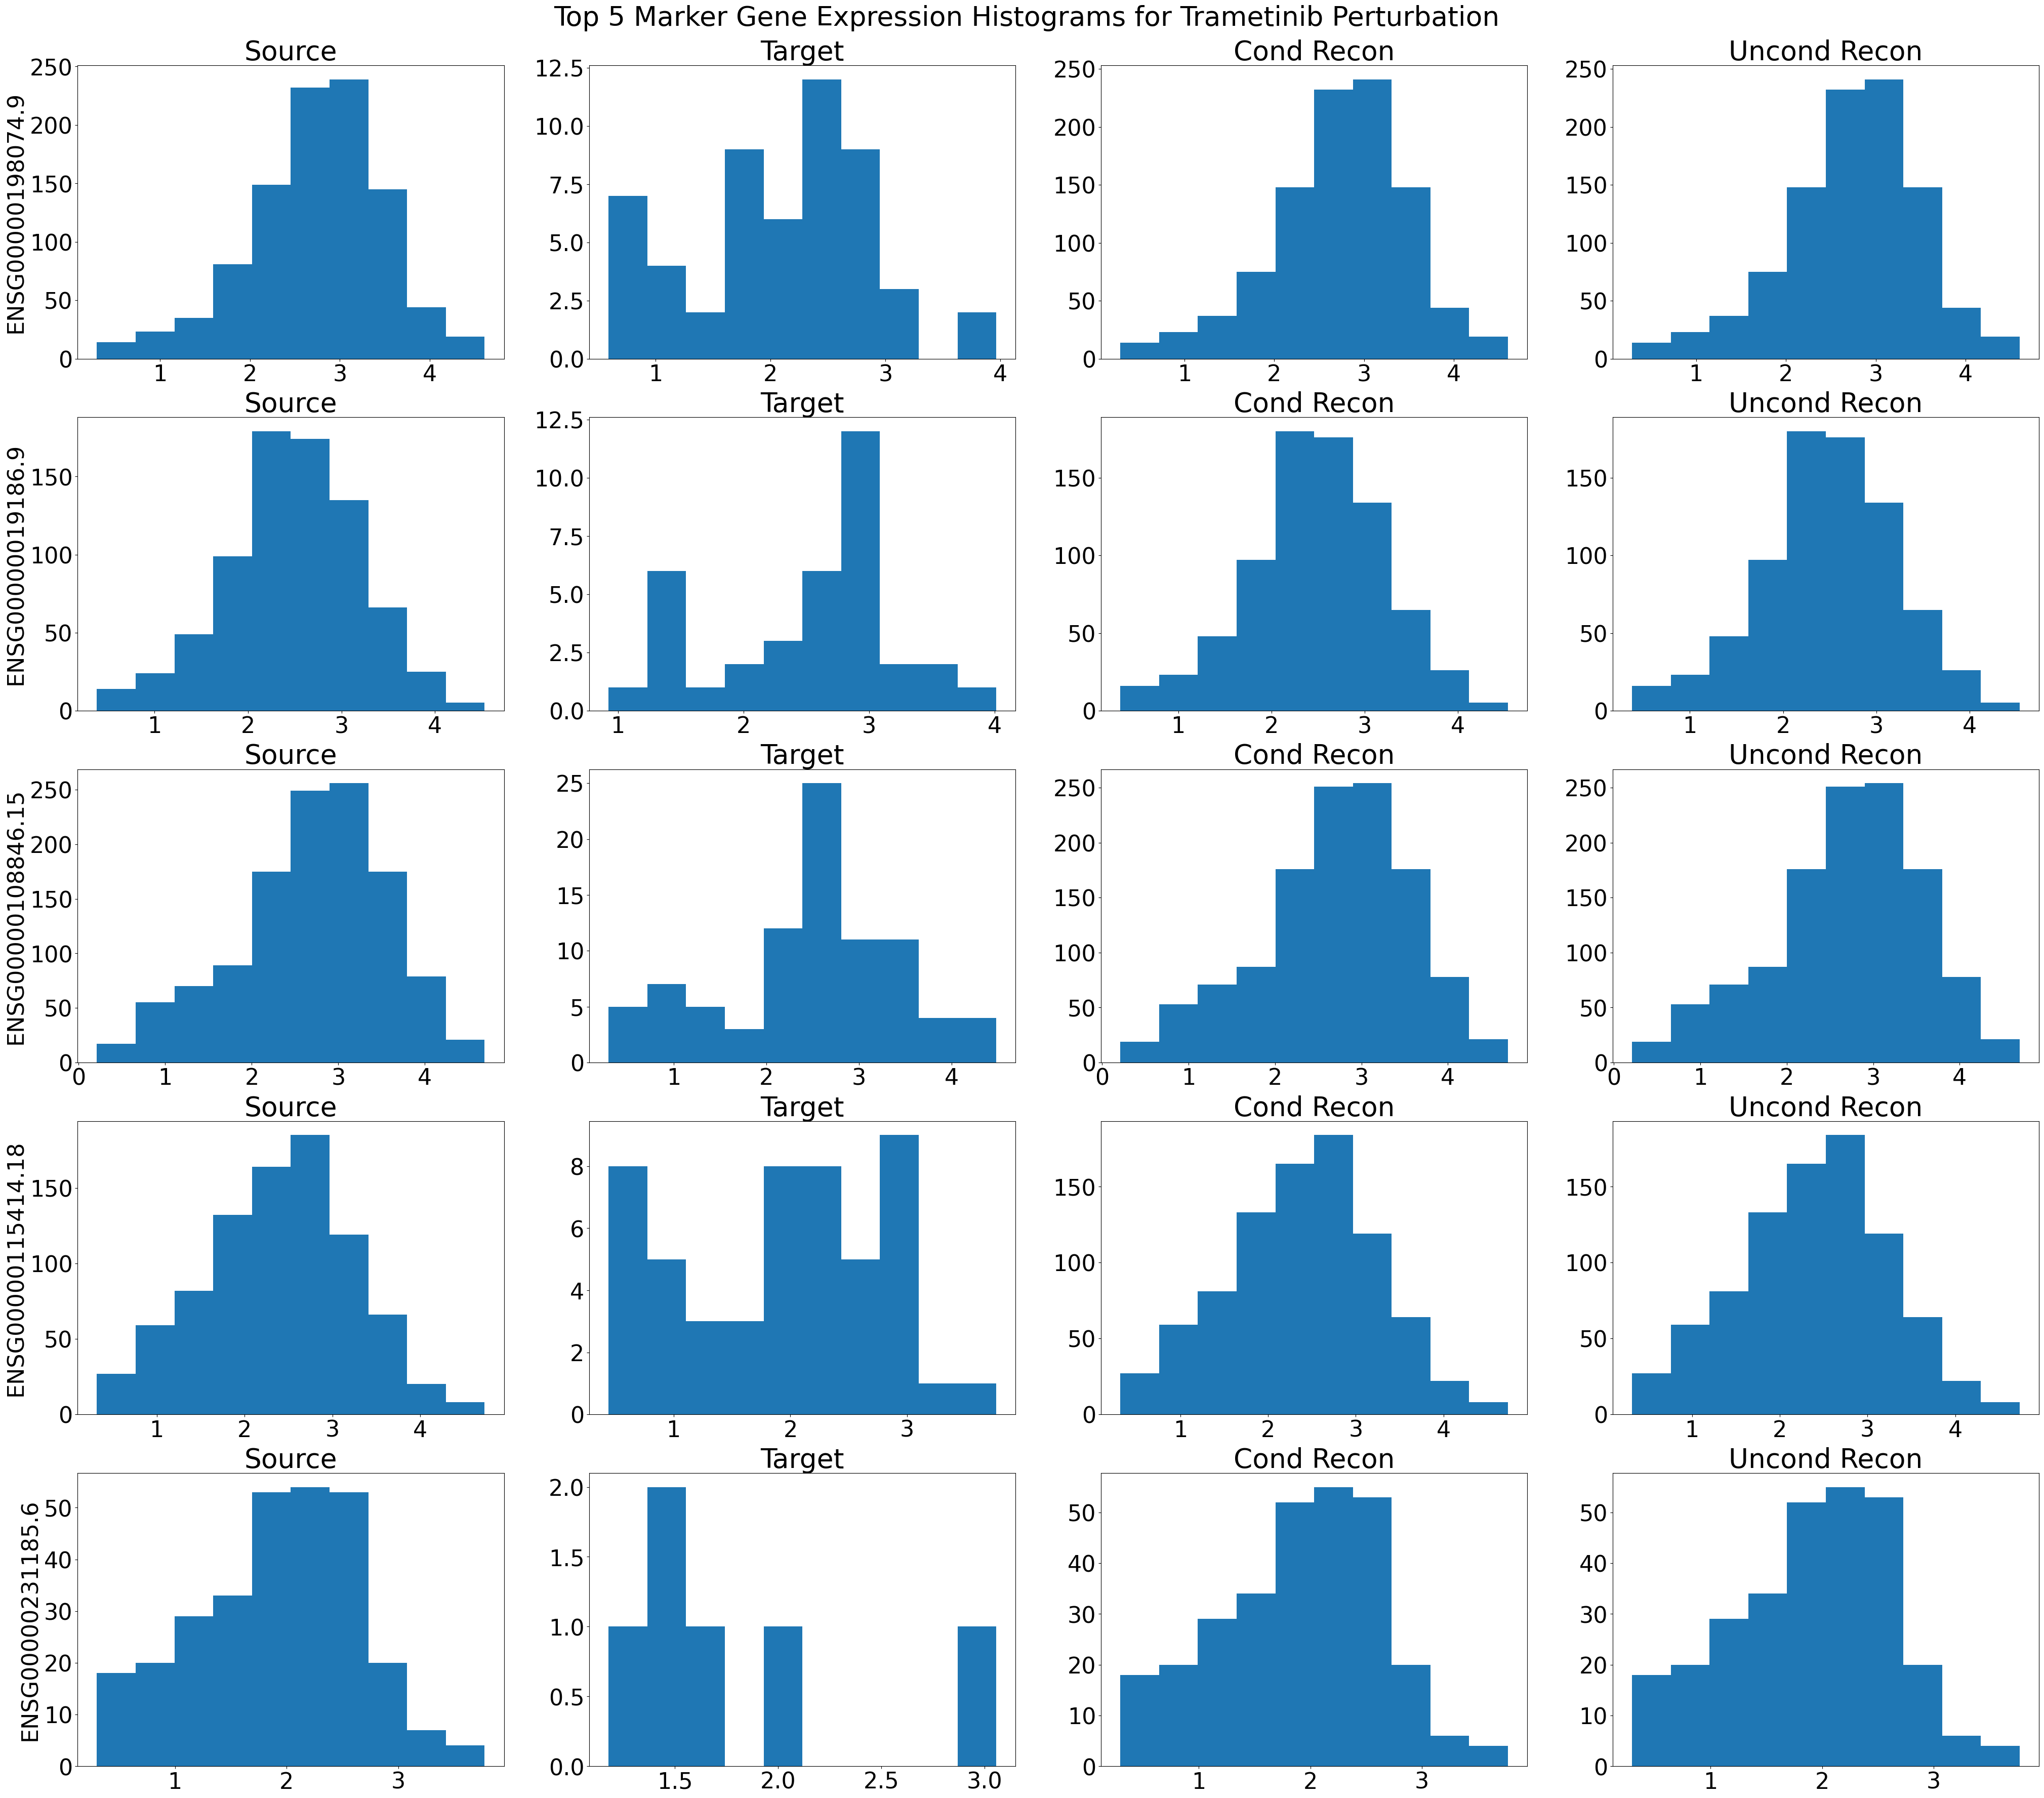

In [101]:
plot_marker_gene_expression(gt_xs, target, all_recons, all_uncond_recons, gene_idxs[:5], sel_mg[:5])

In [ ]:
from cellot import losses
losses.compute_scalar_mmd(all_recon[:, gene_idxs[:50]].detach().cpu().numpy(), sel_target)

0.016602373914793134